In [1]:
# Load and Pre-process the data

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
df = pd.read_csv('/kaggle/input/seattle/listings.csv')
#df.head()

# Import other Useful info
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing


## Clean up the data
# Drop rows with missing review score values
df = df.dropna(subset=['review_scores_rating'], axis=0)

    
#Drop text columns
df = df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description','neighborhood_overview',
             'notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_name','host_since','host_location',
              'host_about','host_response_time','host_thumbnail_url','host_picture_url','street','amenities','calendar_updated','first_review',
             'last_review','latitude','longitude','host_url','host_verifications','host_response_rate','host_listings_count',
              'host_neighbourhood','neighbourhood','zipcode','smart_location','city'], axis=1)


# Replace strings for price values with float values
rows = df.shape[0]

cols = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee']

data_price = []
data_weekly_price = []
data_monthly_price = []
data_security_deposit = []
data_cleaning_fee = []
data_extra_people = []
    
for i in range(rows):
    
    buff = df['price'].iloc[i]    # select df values
    num = float(buff[1:].replace(",", ""))         # transform from string to float value
    data_price.append(num)

    if(type(df['weekly_price'].iloc[i])==str):
        buff = df['weekly_price'].iloc[i]    # select df values
        num = float(buff[1:].replace(",", ""))         # transform from string to float value
        data_weekly_price.append(num)
    else:
        data_weekly_price.append(np.nan)
    
    if(type(df['monthly_price'].iloc[i])==str):
        buff = df['monthly_price'].iloc[i]    # select df values
        num = float(buff[1:].replace(",", ""))         # transform from string to float value
        data_monthly_price.append(num)
    else:
        data_monthly_price.append(np.nan)
        
    if(type(df['security_deposit'].iloc[i])==str):
        buff = df['security_deposit'].iloc[i]    # select df values
        num = float(buff[1:].replace(",", ""))         # transform from string to float value
        data_security_deposit.append(num)
    else:
        data_security_deposit.append(np.nan)
    
    if(type(df['cleaning_fee'].iloc[i])==str):
        buff = df['cleaning_fee'].iloc[i]    # select df values
        num = float(buff[1:].replace(",", ""))         # transform from string to float value
        data_cleaning_fee.append(num)
    else:
        data_cleaning_fee.append(np.nan)
        
    if(type(df['extra_people'].iloc[i])==str):
        buff = df['extra_people'].iloc[i]    # select df values
        num = float(buff[1:].replace(",", ""))         # transform from string to float value
        data_extra_people.append(num)
    else:
        data_extra_people.append(np.nan)
    
    
df = df.drop(['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people'],axis=1)
    
series1 = pd.DataFrame(data = data_price, columns = ["price"])
series2 = pd.DataFrame(data = data_weekly_price, columns = ["weekly_price"])
series3 = pd.DataFrame(data = data_monthly_price, columns = ["monthly_price"])
series4 = pd.DataFrame(data = data_security_deposit, columns = ["security_deposit"])
series5 = pd.DataFrame(data = data_cleaning_fee, columns = ["cleaning_fee"])
series6 = pd.DataFrame(data = data_extra_people, columns = ["extra_people"])

df = pd.concat([df, series1, series2, series3, series4, series5, series6], axis=1)

# Fill numeric columns with the mean
num_vars = df.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
     df[col].fillna((df[col].mean()), inplace=True)

    
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    #for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
# Drop remaining columns with missing values
df = df.dropna(axis=1)

    

/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


/tmp/ipykernel_18/2269652084.py:108: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna((df[col].mean()), inplace=True)


<Axes: >

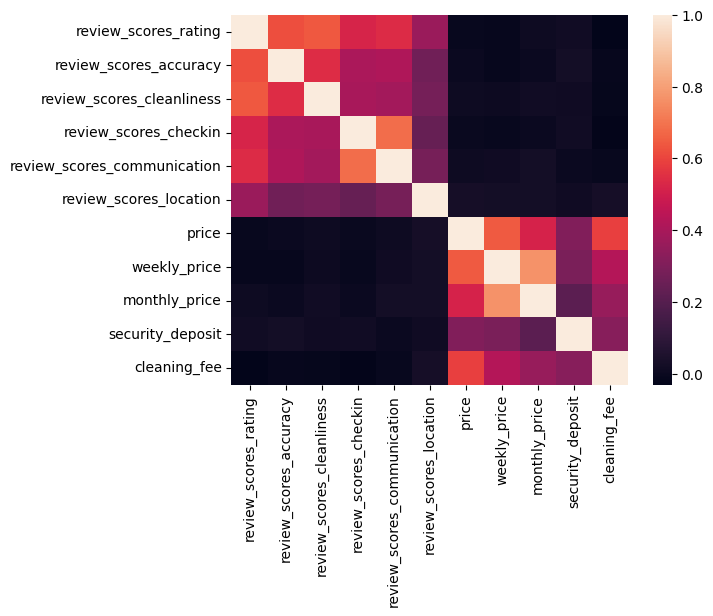

In [2]:
# Plot correlation of review variables
df_scores = df[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                'review_scores_location','price','weekly_price','monthly_price','security_deposit','cleaning_fee']]

sns.heatmap(df_scores.corr(),vmax=1)

In [3]:
# Coefficients weights function
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [4]:
# Normalize data for regression fitting
d = preprocessing.normalize(df)
scaled_df = pd.DataFrame(d,columns=df.columns)

y_score = scaled_df['review_scores_rating']
X_score = scaled_df.drop(['review_scores_rating'],axis=1)

y_price = scaled_df['price']
X_price = scaled_df.drop(['price'],axis=1)

# Train Model for score
X_train, X_test, y_train, y_test = train_test_split(X_score, y_score, test_size=0.3, random_state=1)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

coef_score_df = coef_weights(lm_model.coef_, X_train)

# Train Model for Price
X_train, X_test, y_train, y_test = train_test_split(X_price, y_price, test_size=0.3, random_state=1)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

coef_price_df = coef_weights(lm_model.coef_, X_train)


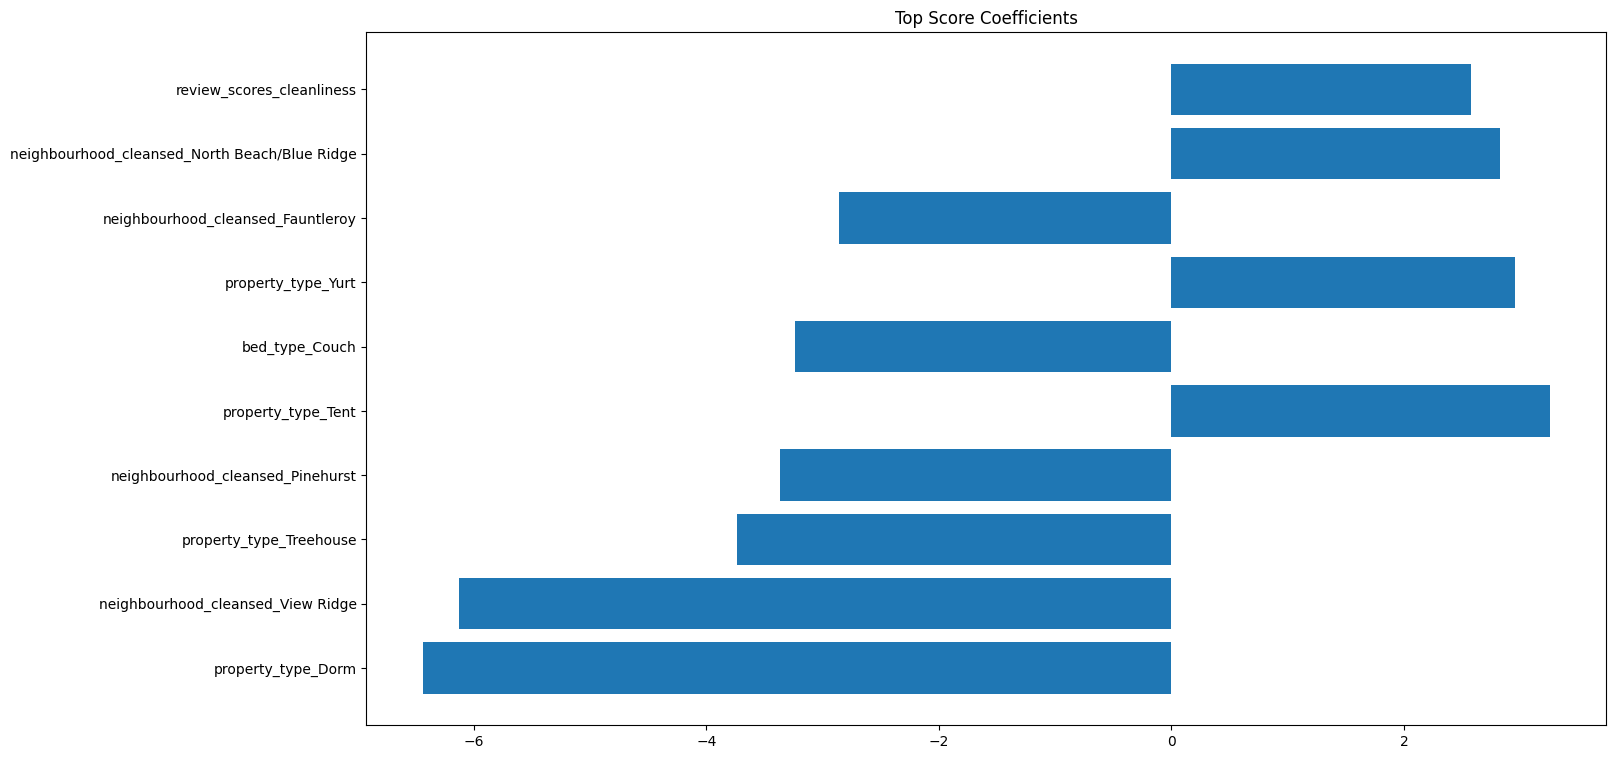

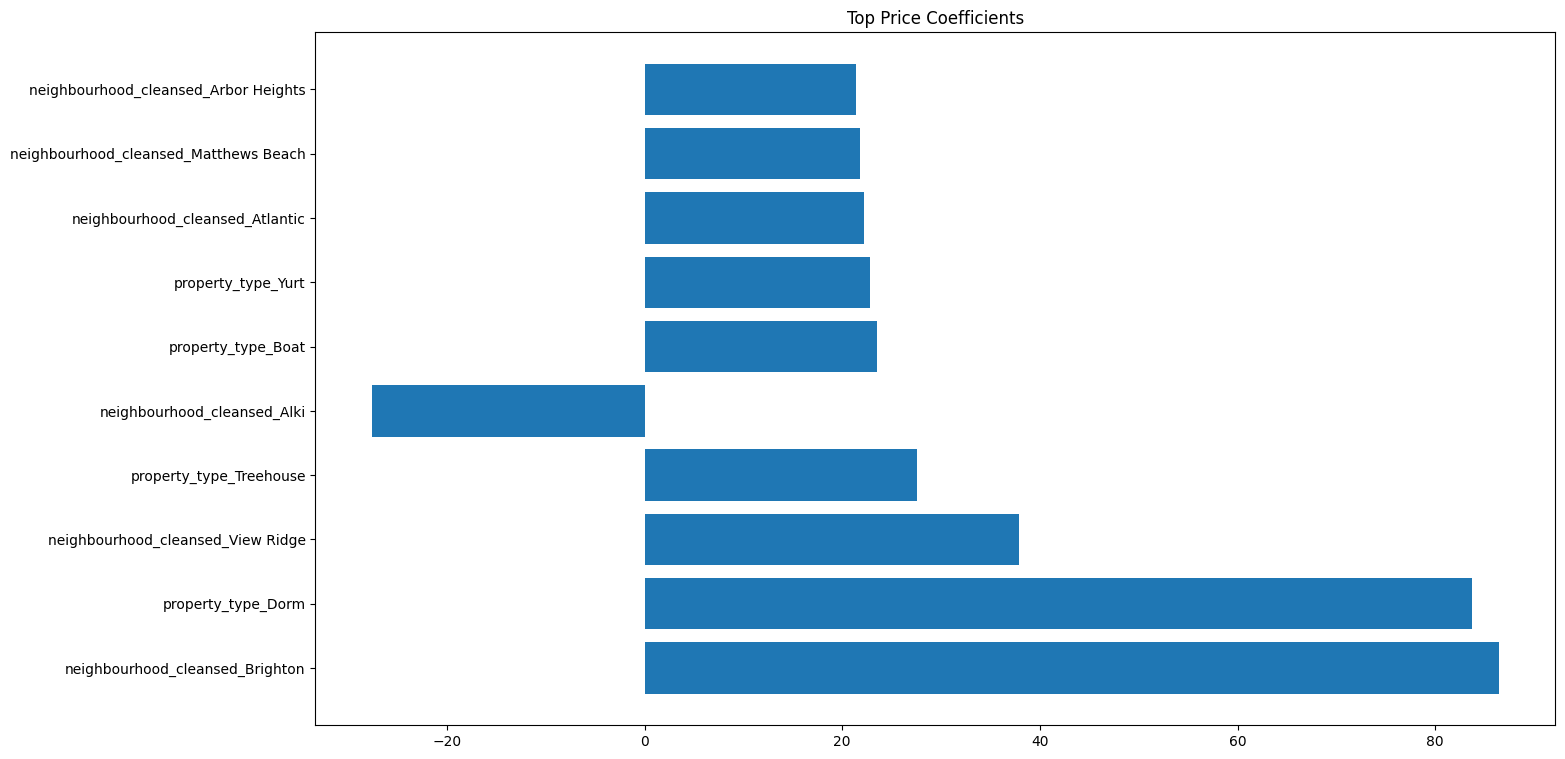

In [5]:
# Plot final model weights

# Horizontal Bar Plot for scores
coef = coef_score_df['est_int'].head(12)
weight = coef_score_df['coefs'].head(12)

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(coef[0:10], weight[0:10])
ax.set_title('Top Score Coefficients')

# Show Plot
plt.show()

# Horizontal Bar Plot for prices
coef = coef_price_df['est_int'].head(12)
weight = coef_price_df['coefs'].head(12)

fig, ay = plt.subplots(figsize =(16, 9))
ay.barh(coef[0:10], weight[0:10])
ay.set_title('Top Price Coefficients')

# Show Plot
plt.show()